In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.neighbors import DistanceMetric
from math import radians

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn import svm
from sklearn import metrics


from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Utilisation du DF nettoyé avec l'exploitation des corrélations et la physique

df = pd.read_csv('df.csv', sep=';') 
df.head()

,Id,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,month,year,season,regions,referent
0,0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,1007.1,8.0,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
1,1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,1007.8,NaN,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
2,2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,1008.7,NaN,2.0,No,No,12,2008,summer,Victoria,WaggaWagga
3,3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,1012.8,NaN,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
4,4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,1006.0,7.0,8.0,No,No,12,2008,summer,Victoria,WaggaWagga


In [3]:
# aus_town_gps : localisation des stations météo (x,y) => 
# ce jeu de données va nous permettre de représenter les indicateurs sur une carte et de calculer des distances entre stations météo

aus_town_gps = pd.read_csv("aus_town_gps.csv")
aus_town_gps.head()

,Location,Latitude,Longitude
0,Albury,-36.065766,146.910315
1,BadgerysCreek,-33.844637,150.755176
2,Cobar,-31.068087,145.664408
3,CoffsHarbour,-30.234976,153.099084
4,Moree,-29.447084,149.839583


In [4]:
# climatsaus : climat des stations méteo

climatsaus = pd.read_csv("climatsAUS_v2.csv", sep=";")
climatsaus.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [5]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.

climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)

In [6]:
#Fusion des dataframes

df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")
df.head(5)

,Id,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,RainTomorrow,month,year,season,regions,referent,Latitude,Longitude,Climat_Koppen,Clim_type
0,0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
1,1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
2,2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
3,3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
4,4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 142192
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Id             142193 non-null  int64  
 1   Date           142193 non-null  object 
 2   Location       142193 non-null  object 
 3   MinTemp        142142 non-null  float64
 4   MaxTemp        142171 non-null  float64
 5   Rainfall       142137 non-null  float64
 6   Evaporation    129224 non-null  float64
 7   Sunshine       123050 non-null  float64
 8   WindGustDir    140552 non-null  object 
 9   WindGustSpeed  140615 non-null  float64
 10  WindDir9am     140410 non-null  object 
 11  WindDir3pm     141823 non-null  object 
 12  WindSpeed9am   142103 non-null  float64
 13  WindSpeed3pm   142025 non-null  float64
 14  Humidity9am    142119 non-null  float64
 15  Humidity3pm    142028 non-null  float64
 16  Pressure3pm    141594 non-null  float64
 17  Cloud9am       133272 non-nul

In [8]:
# conversion de raintoday et raintomorrow en numériques
df['RainToday_Num'] = (df['RainToday'] ==  'Yes')*1
df['RainTomorrow_Num'] = (df['RainTomorrow'] ==  'Yes')*1

In [12]:
#On supprime toutes les observations avec des NA
df1 = df.dropna()

labelencoder = LabelEncoder()
df1['Clim_type1'] = labelencoder.fit_transform(df1['Clim_type'])

#Pour les algos de detection d'anomalie, la convention est de mettre -1 pour la modalité à détecter*/

df1["Class"] = df1["RainTomorrow_Num"]
df1['Class'].replace({1: -1}, inplace=True)
df1['Class'].replace({0: 1}, inplace=True)


features = ["RainToday_Num","MinTemp","MaxTemp","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure3pm","Cloud3pm","Cloud9am", "Clim_type1"]

target = df1["RainTomorrow_Num"]
target_ano = df1["Class"]
data = df1[features]

C:\Users\alain\AppData\Local\Temp\ipykernel_38624\2976945632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Clim_type1'] = labelencoder.fit_transform(df1['Clim_type'])
C:\Users\alain\AppData\Local\Temp\ipykernel_38624\2976945632.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Class"] = df1["RainTomorrow_Num"]
C:\Users\alain\AppData\Local\Temp\ipykernel_38624\2976945632.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [13]:
X_train, X_test, y_train, y_test, y_train_ano, y_test_ano = train_test_split(data, target, target_ano, test_size=0.2, random_state=123)

In [14]:
#Grille de recherche pour avoir les meilleurs hyperparametres pour le criterion et max_depth.

param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split':[300],'min_samples_leaf':[100]}
nfolds = 3

resc_dt = make_scorer(f1_score,pos_label=1)

# decision tree model
dtree_model=DecisionTreeClassifier()
#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring=resc_dt)
#fit model to data
dtree_gscv.fit(X_train, y_train)

dtree_gscv.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 100,
 'min_samples_split': 300}

In [15]:
#Création de l'arbre avec les meilleurs hyperparametres calcules ci dessus

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=7,random_state=123,)
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=7, random_state=123)

In [16]:
y_pred = dt_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## Méthode 2 : à l'aide de pandas
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Accuracy: 0.842760428041057


Classe prédite,0,1
Classe réelle,,
0,16885,906
1,2694,2410


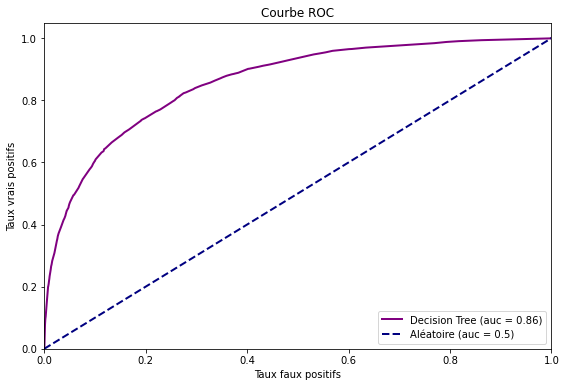

In [17]:
# cette commande permet de tracer et d'évaluer graphiquement la performance d'un modèle de classification binaire, en comparant la courbe ROC du modèle avec celle d'un modèle de classification aléatoire.
# La courbe ROC est utile pour évaluer la performance globale du modèle et pour choisir le seuil de probabilité optimal pour la classification binaire.

probs_dt = dt_clf.predict_proba(X_test)

fpr_dt, tpr_dt, seuils_dt = roc_curve(y_test,probs_dt[:,1],pos_label=1)
#fpr1, tpr1, seuils1 = det_curve(y_test,probs[:,1],pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

In [18]:
ac = AdaBoostClassifier(base_estimator=dt_clf,n_estimators=400)
ac.fit(X_train , y_train)
ac.score(X_test, y_test)

0.8255951081022057

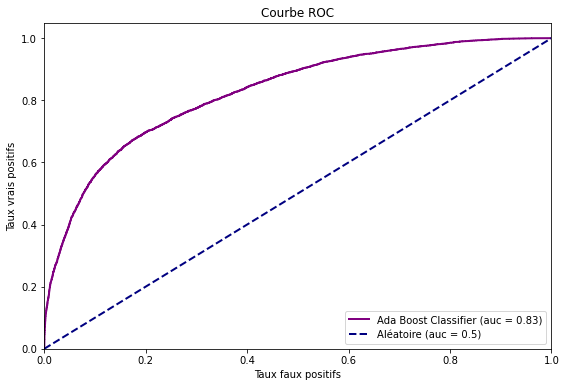

In [19]:
probs_ada = ac.predict_proba(X_test)

fpr_ada, tpr_ada, seuils_ada = roc_curve(y_test,probs_ada[:,1],pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_ada, tpr_ada, color='purple', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

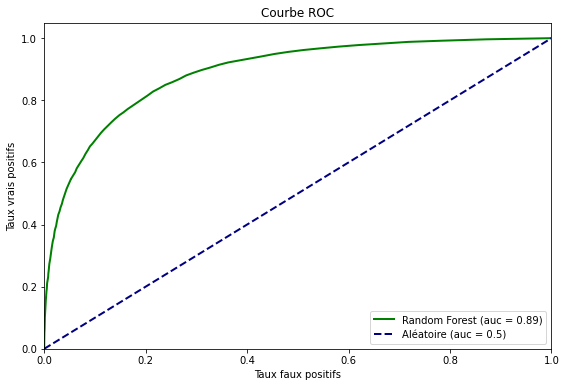

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de forêt aléatoire
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_rf = rf_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_rf, tpr_rf, seuils_rf = roc_curve(y_test,probs_rf[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (auc = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


In [22]:
# Score sur les données de test
score_rf = rf_clf.score(X_test, y_test)

print("Le score du modèle Random Forest sur les données de test est : {:.2f}".format(score_rf))

Le score du modèle Random Forest sur les données de test est : 0.86


C:\Users\alain\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


716/716 [==============================] - 1s 1ms/step


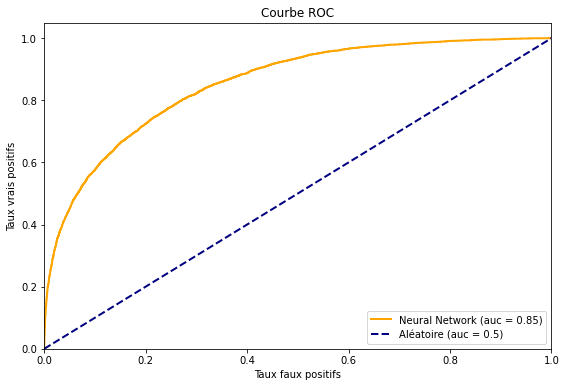

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et compilation d'un modèle de réseau de neurones
nn_clf = Sequential()
nn_clf.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_clf.add(Dense(32, activation='relu'))
nn_clf.add(Dense(1, activation='sigmoid'))
nn_clf.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Entraînement du modèle
history = nn_clf.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Prédiction des probabilités des classes pour les données de test
probs_nn = nn_clf.predict(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_nn, tpr_nn, seuils_nn = roc_curve(y_test,probs_nn,pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_nn, tpr_nn, color='orange', lw=2, label='Neural Network (auc = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Score sur les données de test
score_nn = nn_clf.evaluate(X_test, y_test, verbose=0)[1]

print("Le score du modèle de réseau de neurones sur les données de test est : {:.2f}".format(score_nn))


Le score du modèle de réseau de neurones sur les données de test est : 0.84


C:\Users\alain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


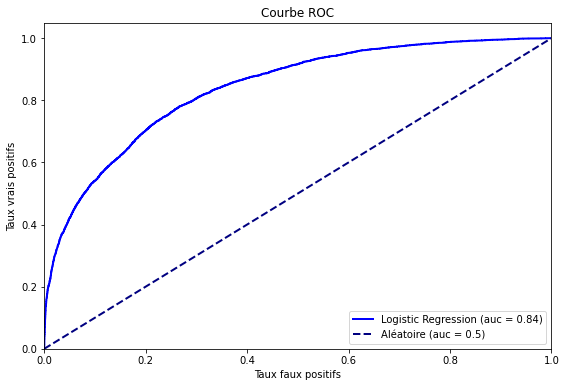

Le score du modèle de régression logistique sur les données de test est : 0.83


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de régression logistique
logreg_clf = LogisticRegression(solver='lbfgs')
logreg_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_logreg = logreg_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_logreg, tpr_logreg, seuils_logreg = roc_curve(y_test,probs_logreg[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Logistic Regression (auc = %0.2f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Score sur les données de test
score_logreg = logreg_clf.score(X_test, y_test)
print("Le score du modèle de régression logistique sur les données de test est : {:.2f}".format(score_logreg))

C:\Users\alain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


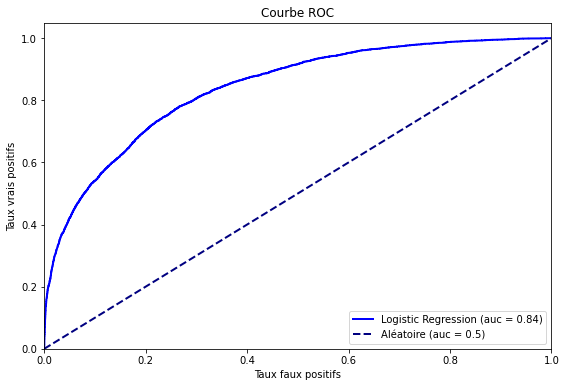

Le score du modèle de régression logistique sur les données de test est : 0.83


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de régression logistique
logreg_clf = LogisticRegression(solver='lbfgs')
logreg_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_logreg = logreg_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_logreg, tpr_logreg, seuils_logreg = roc_curve(y_test,probs_logreg[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Logistic Regression (auc = %0.2f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Score sur les données de test
score_logreg = logreg_clf.score(X_test, y_test)
print("Le score du modèle de régression logistique sur les données de test est : {:.2f}".format(score_logreg))

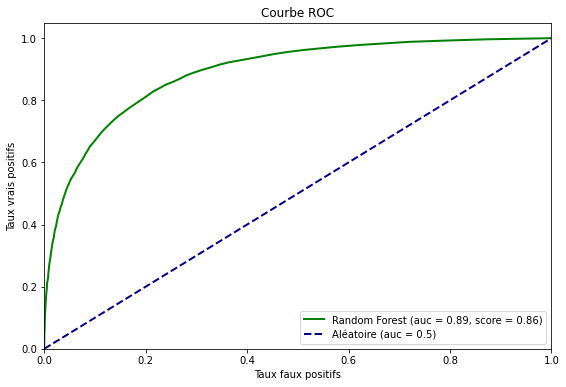

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de forêt aléatoire
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_rf = rf_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_rf, tpr_rf, seuils_rf = roc_curve(y_test,probs_rf[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Score sur les données de test
score_rf = rf_clf.score(X_test, y_test)

# Tracé de la courbe ROC et du score
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (auc = %0.2f, score = %0.2f)' % (roc_auc_rf, score_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

plt.show()


In [29]:
score_rf

0.8577418650360341

In [31]:
import lazypredict

In [32]:
from lazypredict.Supervised import LazyClassifier

In [33]:
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)

In [34]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [26:44<00:00, 55.32s/it] 


In [37]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.75               0.75     0.75      0.77   
QuadraticDiscriminantAnalysis      0.83               0.75     0.75      0.83   
GaussianNB                         0.78               0.75     0.75      0.79   
ExtraTreesClassifier               0.86               0.74     0.74      0.85   
RandomForestClassifier             0.86               0.74     0.74      0.85   
XGBClassifier                      0.85               0.73     0.73      0.84   
LGBMClassifier                     0.85               0.73     0.73      0.84   
SGDClassifier                      0.84               0.73     0.73      0.83   
BernoulliNB                        0.78               0.73     0.73      0.79   
KNeighborsClassifier               0.84               0.73     0.73      0.83   
LinearDiscriminantAnalysis  

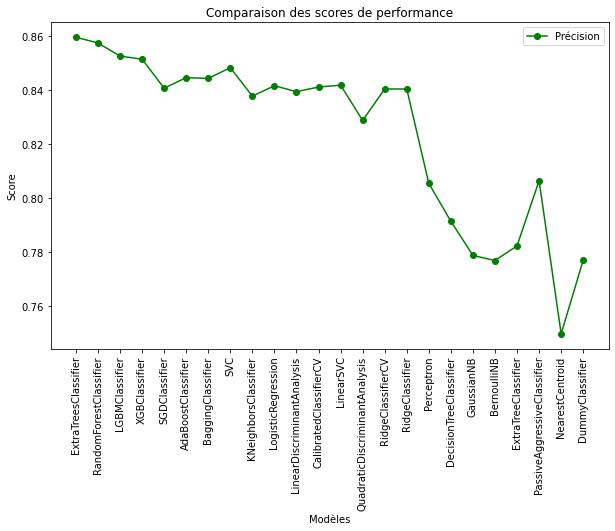

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Convertir les scores de performance en listes
models_list = list(models.index)
accuracy_list = list(models['Accuracy'])
f1_score_list = list(models['F1 Score'])

# Trier les listes par ordre décroissant de score F1
sorted_indices = np.argsort(f1_score_list)[::-1]
models_list = [models_list[i] for i in sorted_indices]
accuracy_list = [accuracy_list[i] for i in sorted_indices]
f1_score_list = [f1_score_list[i] for i in sorted_indices]

# Tracer la courbe de performance
plt.figure(figsize=(10, 6))
#plt.plot(models_list, f1_score_list, '-o', color='blue', label='Score F1')
plt.plot(models_list, accuracy_list, '-o', color='green', label='Précision')
plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des scores de performance')
plt.xticks(rotation=90)
plt.legend()
plt.show()


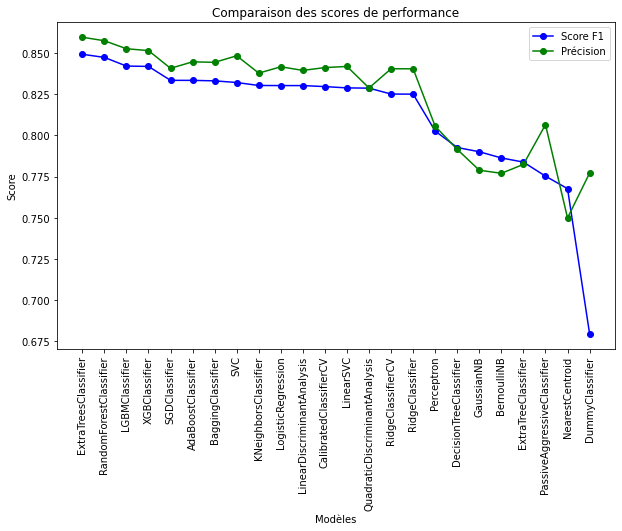

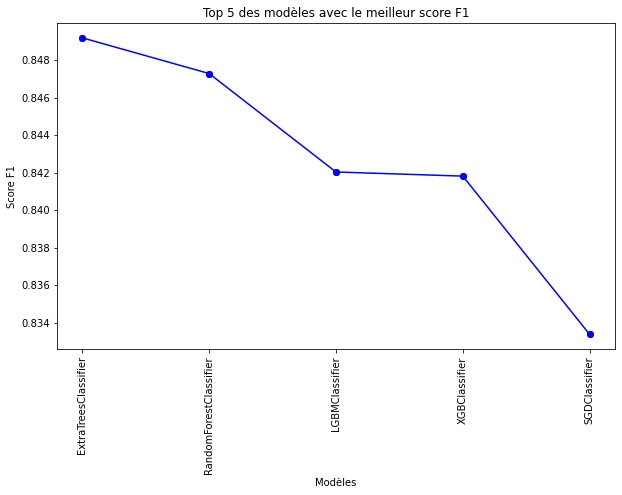

In [44]:
# Tracer la courbe de performance pour les 5 meilleurs modèles
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot([models_list[i]], [f1_score_list[i]], 'o', color='blue')
plt.plot(models_list[:5], f1_score_list[:5], '-o', color='blue')
plt.xlabel('Modèles')
plt.ylabel('Score F1')
plt.title('Top 5 des modèles avec le meilleur score F1')
plt.xticks(rotation=90)
plt.show()
